In [1]:
#Traemos el dataset desde la pagina de github
!wget https://github.com/ecabestadistica/sign-language-translator-python-opencv/raw/master/asl-alphabet.zip

--2023-11-22 15:09:40--  https://github.com/ecabestadistica/sign-language-translator-python-opencv/raw/master/asl-alphabet.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/ecabestadistica/sign-language-translator-python-opencv/master/asl-alphabet.zip [following]
--2023-11-22 15:09:40--  https://media.githubusercontent.com/media/ecabestadistica/sign-language-translator-python-opencv/master/asl-alphabet.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 927976802 (885M) [application/zip]
Saving to: ‘asl-alphabet.zip’

asl-alphabet.zip    100%[===================>] 884.99M  

In [6]:
#simplemente para evitar problemas borramos carpeta previa en ruta de extración
!rm -rf asl-alphabet

In [7]:
#descomprimimos dataset y nos guardamos la ruta
!unzip asl-alphabet.zip
datasetTrainPath='/content/asl-alphabet/asl_alphabet_train'
datasetTestPath='/content/asl-alphabet/asl-alphabet-test'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: asl-alphabet/asl_alphabet_train/X/X190.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1900.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1901.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1902.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1903.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1904.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1905.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1906.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1907.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1908.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1909.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X191.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1910.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1911.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1912.jpg  
  inflating: asl-alphabet/asl_alphabet_train/X/X1913.jpg

In [3]:
#importamos todas las librerias a usar
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices())

from tensorflow.keras                       import regularizers
from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.layers                import *
from tensorflow.keras.callbacks             import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers            import SGD

import matplotlib.pyplot as plt

2.14.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
##Cargamos imagenes de la carpeta en un dataset
bs = 64 #bach size
k = 2

raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  datasetTrainPath,
  label_mode = "categorical",
  seed=123,
  image_size=(28*k, 28*k),
  batch_size=bs)

raw_validation_ds = tf.keras.utils.image_dataset_from_directory(
  datasetTestPath,
  label_mode = "categorical",
  seed=123,
  image_size=(28*k, 28*k),
  batch_size=bs)

Found 72000 files belonging to 24 classes.
Found 720 files belonging to 24 classes.


In [9]:
#definimos clases
class_names = raw_train_ds.class_names
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [10]:
#normalizamos dataset de escala 0,255 a 0,1
normalization_layer = tf.keras.layers.Rescaling(1./255)
tf.keras.layers.RandomZoom(0.05,0.05,)
train_ds = raw_train_ds.map(lambda x, y: (normalization_layer(x), y))
validation_ds = raw_validation_ds.map(lambda x, y: (normalization_layer(x), y))

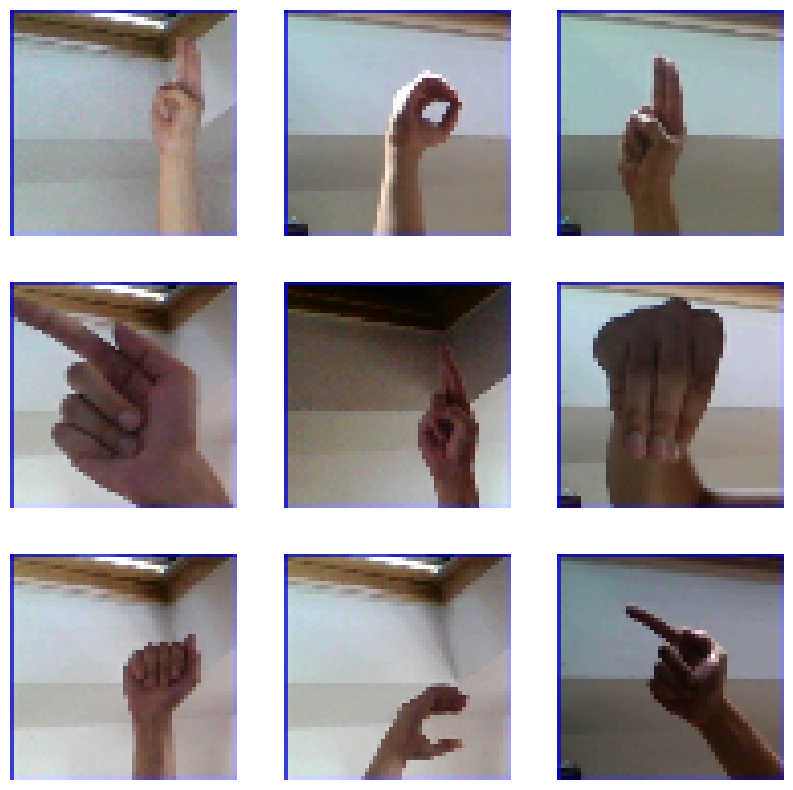

In [11]:
#Mostramos imagen de entrenamiento normalizada sin modificaciones
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy()) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [29]:
#Configuramos nuestra capa de data augmentation
data_augmentation = tf.keras.Sequential(
    [
        #tf.keras.layers.RandomFlip("horizontal"),
        #tf.keras.layers.RandomRotation(0.1),
        #tf.keras.layers.RandomShear(0.3),
        tf.keras.layers.RandomZoom(0.3),
        tf.keras.layers.RandomTranslation(0.2, 0.2),
        tf.keras.layers.RandomBrightness([-0.1,0.2],value_range=(0, 1)),
        #tf.keras.layers.RandomCrop(25,25),
        #tf.keras.layers.RandomContrast(0.3)
    ]
)

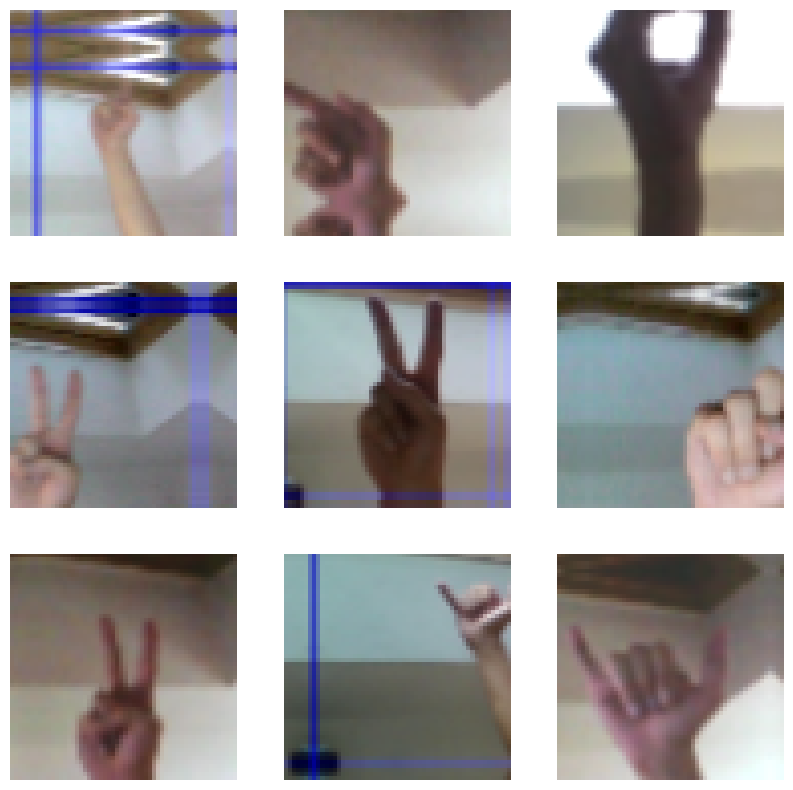

In [30]:
#probamos nuestro data augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  #images contiene un batch(32) de imagenes de 56x56x3
  #labels contiene un array de 32 arrays con 10 clases marcando un 1 o 0 dependiendo de la clase de cada imagen
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(data_augmentation(images[i].numpy())) ## usar .astype("uint8") si las imagenes van de 0 a 255 si no float 0 a 1
    #plt.title(class_names[labels[i].numpy().tolist().index(1)-2])
    plt.axis("off")

In [22]:
# VGG19
# Importamos el modelo base que queremos utilizar con los argumentos que queremos
VGG19_model = tf.keras.applications.VGG19(input_shape=(28*k,28*k,3),
                                          include_top=False,
                                          weights='imagenet')

#Congelamos  las 6 primeras caps del modelo para proceder a entrenar las demás
for layer in VGG19_model.layers[:6]:
  layer.trainable = False

##DEFINIMOS EL MODELO

epochs = 15

# Creamos un nuevo modelo vacio.
model = tf.keras.Sequential()

# Añadimos el modelo preentrenado como si se tratase de una capa.
model.add(VGG19_model)

# Continuamos añadiendo más capas que sí serán entrenadas...
model.add(data_augmentation)
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(64, kernel_regularizer=regularizers.l2(0.01), activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(len(class_names), activation = 'softmax'))

model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 sequential_4 (Sequential)   (56, 56, 3)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                       

In [23]:
## EJECUCION DEL MODELO
model.compile(loss="categorical_crossentropy",
              optimizer= SGD(learning_rate=0.001),
              metrics=['accuracy'])

#Agregamos un callback para guardar checkpoints y modificar el learning rate dinamicamente
#checkpointer = ModelCheckpoint(filepath='model', verbose=1, save_best_only=True,
#                               monitor = 'val_accuracy', mode = 'max')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=3, min_lr=0.000001)

history = model.fit(train_ds,validation_data = validation_ds,
                             callbacks = [
#                                 reduce_lr,
#                                 checkpointer
                                ],
                   epochs=epochs)

Epoch 1/15
2250/2250 [==============================] - 134s 54ms/step - loss: 2.1857 - accuracy: 0.6640 - val_loss: 4.9414 - val_accuracy: 0.3917
Epoch 2/15
2250/2250 [==============================] - 119s 53ms/step - loss: 1.1099 - accuracy: 0.9646 - val_loss: 5.4261 - val_accuracy: 0.4125
Epoch 3/15
2250/2250 [==============================] - 118s 52ms/step - loss: 0.9584 - accuracy: 0.9867 - val_loss: 5.9630 - val_accuracy: 0.4139
Epoch 4/15
2250/2250 [==============================] - 117s 52ms/step - loss: 0.8609 - accuracy: 0.9928 - val_loss: 6.0661 - val_accuracy: 0.4264
Epoch 5/15
2250/2250 [==============================] - 118s 53ms/step - loss: 0.7807 - accuracy: 0.9955 - val_loss: 6.1310 - val_accuracy: 0.4167
Epoch 6/15
2250/2250 [==============================] - 119s 53ms/step - loss: 0.7120 - accuracy: 0.9962 - val_loss: 6.3964 - val_accuracy: 0.4153
Epoch 7/15
2250/2250 [==============================] - 119s 53ms/step - loss: 0.6484 - accuracy: 0.9975 - val_loss: 6

KeyboardInterrupt: ignored

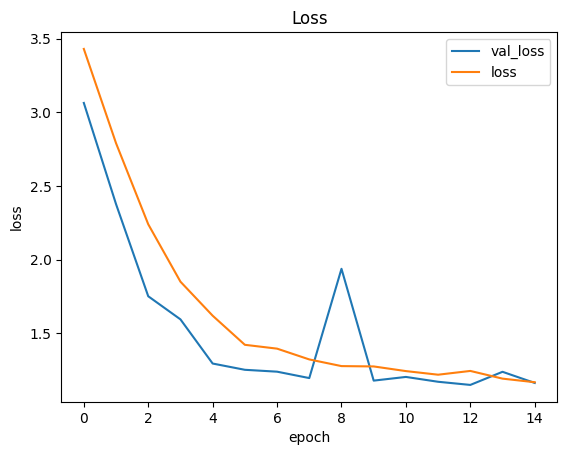

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['val_loss','loss'])
plt.show()

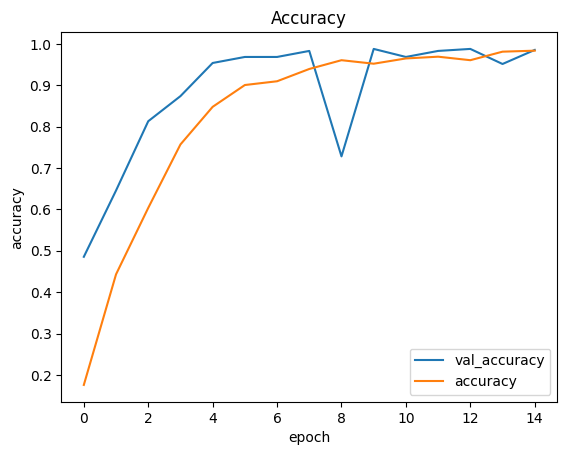

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['val_accuracy','accuracy'])
plt.show()